# Escenario 1.2. - Alice y Bob con clave

En este escenario se cubre el caso en el que Alice cifra para Bob y Bob descifra los mensajes por medio de una clave.

Se lleva a cabo un entrenamiento, una evaluación de los resultados y se dibuja una gráfica para ilustrarlos. Como se hacen muchas ejecuciones, se grafica el resultado obtenido en cada ejecución. Hay cierta variabilidad en los resultados al ser los pesos de las redes neuronales aleatorios, así como los mensajes generados en el entrenamiento y la evaluación.

## Imports

In [41]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.regularizers import l2

from data_utils import generar_mensajes

import time as t
import numpy as np
import math
import matplotlib.pyplot as plt

from IPython.display import clear_output

## Las redes neuronales

En esta sección definimos las redes a utilizar más adelante.

**Alice**: Red neuronal que cifra los mensajes.
1. Recibe como parámetro el número de bits de los mensajes que va a cifrar y entonces define la forma de entrada.
2. Concatena el mensaje de entrada con al clave y eso es lo que se le pasa a la red, para así cifrar el mensaje.
3. final_input va a recibir algo de la forma mensaje + clave, por lo que esta vez recibe una dupla.
4. Va a tener dos capas, con 128 y 64 neuronas, que reciben la entrada de la anterior y usan la función de activación relu. _Dense_ quiere decir que la capa está completamente conectada con la anterior.

La última capa tiene una función de activación lineal porque luego la va a procesar Bob. No es necesario que sea binaria todavía. Tiene también tantas neuronas como bits, porque se busca que saque el mensaje cifrado y, por último, la función kernel_regularizer ayuda a evitar el sobreajuste penalizando las capas, de forma a que afecta la función de pérdida/coste.

In [42]:
def crear_modelo_alice(bits):
    input_msg = Input(shape=(bits,), name='mensaje_original') 

    input_key = Input(shape=(bits,), name='clave_simetrica') 
    x = Concatenate()([input_msg, input_key]) 
    final_input = [input_msg, input_key]

    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)

    cifrado = Dense(bits, activation='linear', kernel_regularizer=l2(0.01))(x)
    return Model(final_input, cifrado, name='Alice')

**Bob**: Red neuronal que descifra los mensajes.
Funciona parecido a Alice, salvo que tiene capas de 64 y 64 neuronas. 
Lo más destacable es que la función de activación de la última capa es, en este caso, la función sigmoide. La función sigmoide devuelve un valor entre 0 y 1 y esos son los valores que luego se procesan para inferir si la predicción es el valor 0 o el valor 1 en la reconstrucción.

Además, en este escenario cabe destacar que el mensaje cifrado de entrada y la clave recibida se concatenan, para llevar a cabo el descifrado.

In [43]:
def crear_modelo_bob(bits):
    input_cifrado = Input(shape=(bits,), name='mensaje_cifrado')

    input_key = Input(shape=(bits,), name='clave_simetrica')
    x = Concatenate()([input_cifrado, input_key])
    final_input = [input_cifrado, input_key]

    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)

    reconstruido = Dense(bits, activation='sigmoid')(x)
    return Model(final_input, reconstruido, name='Bob')

## Código de entrenamiento

Esta sección se encarga de entrenar los modelos de Alice y Bob. Tiene tres métodos:
* El método crear_modelo_conjunto, que crea el modelo a entrenar de forma conjunta. El por qué se verá en el escenario 1.3.
* El método entrenar_modelo, que entrena ese modelo conjunto.
* El método principal entrenar, que utiliza los método anteriores para instanciar las redes neuronales, entrenarlas y guardar los modelos, lo cuál es vital para luego poder utilizarlos en la evaluación.

Nótese que se recoge la duración del entrenamiento.

In [44]:
def crear_modelo_conjunto(bits):
    alice = crear_modelo_alice(bits)
    bob = crear_modelo_bob(bits)

    # Modelo combinado con clave
    mensaje_input, clave_input = alice.input
    cifrado_output = alice.output

    # Recibe la input de Alice y Bob recibe su salida y la clave, se entrenarán conjuntamente
    modelo = Model([mensaje_input, clave_input], bob([cifrado_output, clave_input]))

    return alice, bob, modelo

In [45]:
def entrenar_modelo(modelo, n_mensajes, epochs, mensajes, batch_size):
    for epoch in range(epochs):
        if epoch % 100 == 0:
            clear_output(wait=True)

        # Se selecciona un batch aleatorio de mensajes, que es lo que va en mensajes_batch para evitar overfitting
        idx = np.random.choice(n_mensajes, batch_size)
        mensajes_batch = mensajes[idx]

        # Se generan claves en cada batch
        claves_batch = np.random.randint(0, 2, size=(batch_size, bits)).astype(np.float32)
            
        # Entrenamiento con clave
        modelo.train_on_batch([mensajes_batch, claves_batch], mensajes_batch)
        reconstruidos = modelo.predict([mensajes_batch, claves_batch])
           
        # Media de todos los reonstruidos correctamente
        precision = np.mean((reconstruidos > 0.5).astype(int) == mensajes_batch)
        print(f"Epochs totales: {epochs} | Epoch {epoch+1} - Precisión del descifrado: {precision:.3f}")

In [46]:
def entrenar(n_mensajes, bits, epochs, batch_size, adam_optimizer):
    # Generamos los mensajes
    mensajes = generar_mensajes(n_mensajes, bits)

    alice, bob, modelo = crear_modelo_conjunto(bits)

    # Se prepara el modelo para entrenarlo con Adam y BinaryCrossEntropy
    modelo.compile(optimizer=Adam(adam_optimizer), loss=BinaryCrossentropy())

    time_0 = t.time()
    
    # Comienza el entrenamiento
    entrenar_modelo(modelo, n_mensajes, epochs, mensajes, batch_size)

    time = t.time() - time_0
  
    alice.save('modelo_alice_key.keras')
    bob.save('modelo_bob_key.keras')

    return time

## Código de evaluación

Esta sección se encarga de evaluar el entrenamiento y consiste en lo siguiente:
* El método cargar_modelos, que crea a Alice y a Bob y les carga los pesos finales obtenidos en el entrenamiento.
* El método generar_cifrados, que genera los mensajes cifrados que Bob intenta reconstruir.
* El método analizar_resultados, que recoge una serie de métricas: la precisión media, la distancia de Hamming media y el número de reconstrucciones perfectas obtenido.
* El método analizar_resultados_claves_erroneas, que reune las mismas métricas pero para reconstrucciones que hace Bob con claves que no son los que se usaron para cifrar. Las claves se generan aleatoriamente, pero hay 2^32 opciones, por lo que la probabilidad de que las 10000 generadas coincidan es mínima.
* El método evaluar, que usa los anteriores para llevar a cabo la evaluación. Este método devuelve las métricas que luego se enviarán al método que dibuja las gráficas.

Nótese que también se incluye el escribir en un fichero de texto los resultados. Así se pueden consultar los resultados exactos más fácilmente.

In [47]:
def cargar_modelos(bits):
    # Cargamos los modelos y los pesos del entrenamiento anterior
    alice = crear_modelo_alice(bits)
    bob = crear_modelo_bob(bits)

    # Se cargan los pesos del entrenamiento anterior
    alice.load_weights('modelo_alice_key.keras')
    bob.load_weights('modelo_bob_key.keras')

    return alice, bob

In [48]:
def generar_cifrados(bits, alice, bob, mensajes):
    claves = np.random.randint(0, 2, size=(mensajes.shape[0], bits))
    cifrados = alice.predict([mensajes, claves])
    reconstruidos = bob.predict([cifrados, claves])

    return cifrados, reconstruidos

In [49]:
def analizar_resultados(muestras, res_file_name, mensajes, reconstruidos):

    precisiones = []
    distancias = []
    reconstrucciones_perfectas = 0

    for i in range(len(reconstruidos)):
        
        original = mensajes[i].astype(int)
        reconstruido = (reconstruidos[i] > 0.5).astype(int)
        
        # Coges el original y el reconstruido y haces la media de cuántos bits se parecen
        precision = np.mean(original == reconstruido)
        distancia_hamming = np.sum(original != reconstruido)

        if i < muestras:

            str_mensaje_original = f"Original     --> {original}\n"
            str_mensaje_reconstruido = f"Reconstruido --> {reconstruido} | Precisión: {precision:.2f}\n"
            str_distancia_hamming = f"Distancia de Hamming: {distancia_hamming}\n"
            str_mensaje_delimiter = ("-" * 50) + "\n"
            str_muestra = str_mensaje_original + str_mensaje_reconstruido + str_distancia_hamming + str_mensaje_delimiter
            with open(res_file_name, "a") as f:
                f.write(str_muestra)


        precisiones.append(precision)
        distancias.append(distancia_hamming)
        if distancia_hamming == 0:
            reconstrucciones_perfectas += 1

    return precisiones, distancias, reconstrucciones_perfectas

In [50]:
def analizar_resultados_claves_erroneas(bits, bob, muestras, res_file_name, mensajes, cifrados):

    precision_errores = []
    dist_errores = []
    reconstrucciones_perfectas_errores = 0

    claves_erroneas = np.random.randint(0, 2, size=(mensajes.shape[0], bits)).astype(np.float32)
    reconstruidos_bob_errados = bob.predict([cifrados, claves_erroneas])

    for i in range(muestras):
        original = mensajes[i].astype(int)
        reconstruidos_bob_err = (reconstruidos_bob_errados[i] > 0.5).astype(int)
        
        acc_err = np.mean(original == reconstruidos_bob_err)
        hamming_err = np.sum(original != reconstruidos_bob_err)

        str_errores = f"[{i+1}] Bob (clave errada) --> {reconstruidos_bob_err} | Precisión: {acc_err:.2f} | Hamming: {hamming_err}\n"
        str_errores_delimiter = ("-" * 60) + "\n"
        str_errores_final = str_errores + str_errores_delimiter

        with open(res_file_name, "a") as f:
            f.write(str_errores_final)

        precision_errores.append(acc_err)
        dist_errores.append(hamming_err)
        if(hamming_err == 0):
            reconstrucciones_perfectas_errores += 1

    return precision_errores, dist_errores, reconstrucciones_perfectas_errores

In [51]:
def evaluar(n_mensajes, bits, muestras, res_file_name, epochs):

    # Cargamos los modelos y los pesos del entrenamiento anterior
    alice, bob = cargar_modelos(bits)

    # Generamos los mensajes
    mensajes = generar_mensajes(n_mensajes, bits)
    
    # Se cogen los mensajes y se cifran con las claves suficientes
    cifrados, reconstruidos = generar_cifrados(bits, alice, bob, mensajes)

    with open(res_file_name, "a") as f:
        f.write(f"\nEVALUACIÓN CON {epochs}:\n\n")
    
    precisiones, distancias, reconstrucciones_perfectas = analizar_resultados(muestras, res_file_name, mensajes, reconstruidos)
    
    media_precision = np.mean(precisiones)
    media_distancias = np.mean(distancias)
    str_media_precision = f"La media de la precisión del descifrado es {media_precision:.4f}\n"
    str_media_distancias = f"Distancia media de Hamming = {media_distancias:.4f} | Número de bits: {bits}\n"
    str_reconstrucciones_perfectas = f"Número de reconstrucciones perfectas = {reconstrucciones_perfectas}\n"
    str_medidas = str_media_precision + str_media_distancias + str_reconstrucciones_perfectas + "\n\n"
    with open(res_file_name, "a") as f:
        f.write(str_medidas)

    
    with open(res_file_name, "a") as f:
        f.write('\n EVALUACIÓN DE BOB CON CLAVES ERRÓNEAS\n\n')

    precision_errores, dist_errores, reconstrucciones_perfectas_errores = analizar_resultados_claves_erroneas(bits, bob, muestras, res_file_name, mensajes, cifrados)

    media_precision_errores = np.mean(precision_errores)
    media_distancia_errores = np.mean(dist_errores)

    with open(res_file_name, "a") as f:
        f.write("\nRESULTADOS CON CLAVES ERRÓNEAS\n\n")
        f.write(f"Bob -> Precisión media (clave errada): {media_precision_errores:.4f} | Hamming media: {media_distancia_errores:.2f}\n")
        f.write(f"Bob -> Reconstrucciones perfectas (con clave errada): {reconstrucciones_perfectas_errores}\n\n\n")
    
    return [media_precision, media_distancias, reconstrucciones_perfectas, media_precision_errores, media_distancia_errores, reconstrucciones_perfectas_errores]

## Representando los resultados

Tan importante como desarrollar un buen código, es poder enseñar los resultados de manera ilustrativa. Para ello, en esta sección se define la creación de una gráfica para poder visualizar los resultados obtenidos en la ejecución. Las métricas se recogen en el main y se guardan en un diccionario. Así mismo, también recibe el nombre de la figura, al que simplemente se le añade el formato al guardarla y el número de mensajes, que es útil para establecer un límite en la gráfica que muestra las reconstrucciones perfectas realizadas.

In [52]:
import matplotlib.pyplot as plt

def draw_graph(diccionario_medidas, n_mensajes, nombre_figura):

    list_epochs = diccionario_medidas["epochs"]
    list_training_times = diccionario_medidas["training_times"]
    list_media_precision = diccionario_medidas["media_precision"]
    list_media_distancias = diccionario_medidas["media_distancias"]
    list_reconstrucciones_perfectas = diccionario_medidas["reconstrucciones_perfectas"]
    list_media_errores = diccionario_medidas["precision_errores"]
    list_dist_errores = diccionario_medidas["dist_errores"]
    list_reconstrucciones_perfectas_errores = diccionario_medidas["reconstrucciones_perfectas_errores"]

    plt.subplot(2, 2, 1)
    plt.plot(list_epochs, list_training_times, c="red", marker='o', markersize=3, markerfacecolor="red")
    plt.xlabel("Número de epochs")
    plt.ylabel("Duración entrenamiento (s)")
    plt.title("Entrenamiento - Epochs")
    plt.xlim(left = 0)
    plt.ylim(bottom = 0)

    plt.subplot(2, 2, 2)
    plt.plot(list_epochs, list_media_precision, c="red", label = "Prec correcta", marker='o', markersize=3, markerfacecolor="red")
    plt.plot(list_epochs, list_media_errores, c="blue", label = "Prec errónea", linestyle="dashed", marker='o', markersize=3, markerfacecolor="blue")
    plt.xlabel("Número de epochs")
    plt.ylabel("Media precisión descifrado")
    plt.title("Precisión media - Epochs")
    plt.legend()
    plt.xlim(left = 0)

    plt.subplot(2, 2, 3)
    plt.plot(list_epochs, list_media_distancias, c="red", label = "Dist correctas", marker='o', markersize=3, markerfacecolor="red")
    plt.plot(list_epochs, list_dist_errores, c="blue", label = "Dist errores", linestyle="dashed", marker='o', markersize=3, markerfacecolor="blue")
    plt.xlabel("Número de epochs")
    plt.ylabel("Media distancias de Hamming")
    plt.title("Distancias de Hamming - Epochs")
    plt.legend()
    plt.xlim(left = 0)
    plt.ylim(bottom = 0)

    plt.subplot(2, 2, 4)
    plt.plot(list_epochs, list_reconstrucciones_perfectas, c="red", label = "Rec perfectas", marker='o', markersize=3, markerfacecolor="red")
    plt.plot(list_epochs, list_reconstrucciones_perfectas_errores, c="blue", label = "Rec errores", linestyle="dashed", marker='o', markersize=3, markerfacecolor="blue")
    plt.xlabel("Número de epochs")
    plt.ylabel("Reconstrucciones perfectas")
    plt.title("Reconstrucciones perfectas - Epochs")
    plt.legend()
    plt.xlim(left = 0)
    plt.ylim(0, n_mensajes)

    plt.subplots_adjust(left = 0.125, bottom = 0.11, right = 1.1, top = 0.9, wspace = 0.44, hspace = 0.45)
    plt.savefig(nombre_figura + ".png", bbox_inches='tight', dpi = 300)
    plt.show()


## Código principal

Aquí se define el código principal. Este es un main que tiene un bucle que ejecuta el código una vez. Con ayuda de bucles se puede conseguir que se ejecute más veces, y es lo que se hizo para obtener los resultados más cómodamente, pero en este caso, en pro de visualizar la gráfica resultante, se ha dejado una sola  ejecución.

Aquí es donde se definen los hiperparámetros que se utilizarán, como el tamaño del _batch_.

La ejecución tarda en completarse, puede llegar a una hora. Por ello, se han dejado los mensajes que Tensorflow y Keras imprimen por pantalla y se ha añadido uno, que sale en cada ronda de entrenamiento y da información acerca de por dónde y cómo va. Hay mucha salida, pero el tamaño queda limitado.

Además, aquí se recogen las métricas que se usan para dibujar las gráficas, los métodos de entrenamiento y evaluación devuelven el tiempo que duró el entrenamiento y las métricas recogidas durante la evaluación.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epochs totales: 600 | Epoch 501 - Precisión del descifrado: 0.919
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epochs totales: 600 | Epoch 502 - Precisión del descifrado: 0.915
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epochs totales: 600 | Epoch 503 - Precisión del descifrado: 0.919
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epochs totales: 600 | Epoch 504 - Precisión del descifrado: 0.916
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epochs totales: 600 | Epoch 505 - Precisión del descifrado: 0.915
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epochs totales: 600 | Epoch 506 - Precisión del descifrado: 0.919
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epochs totales: 600 | Epoch 507 - Precisión del descifrado: 0.916
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epochs totales: 600 | Epoch 508 - Precisión del descifrado: 0.917
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epochs totales: 600 | Epoch 509 - Precisión del descifrado: 0.921
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epochs

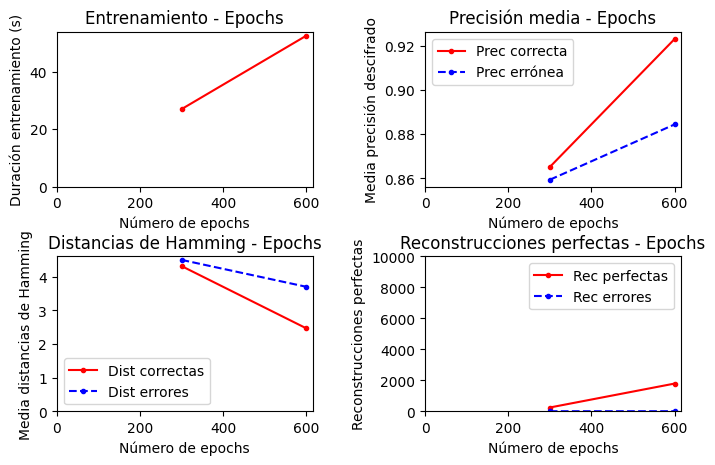

In [53]:
if __name__ == '__main__':


    n_mensajes = 10000
    bits = 32
    batch_size = 512
    adam_optimizer = 0.001
    muestras = 10
    
    epochs = 300
    step = 300
    total_epochs = 6000

    res_file_name = f"Resultados_12_{batch_size}_{adam_optimizer}.txt"
    nombre_figura = f"Figura 12 - {batch_size} y {adam_optimizer}"
    with open(res_file_name, "w") as f:
        f.write("-- RESULTADOS DEL EXPERIMENTO 1.2. --\n\n")
            

        diccionario_medidas = {
            "epochs": [],
            "training_times": [],
            "media_precision": [],
            "media_distancias": [],
            "reconstrucciones_perfectas": [],
            "precision_errores": [],
            "dist_errores": [],
            "reconstrucciones_perfectas_errores": []
        }

        with open(res_file_name, "a") as f:
            f.write(f"Número de mensajes = {n_mensajes}\n")
            f.write(f"Número de bits = {bits}\n")
            f.write(f"Tamaño del batch = {batch_size}\n")
            f.write(f"Adam optimizer learning rate = {adam_optimizer}\n")
            f.write(f"Epochs totales = {total_epochs}\n")
            f.write(f"Epochs iniciales = {epochs}\n")
            f.write("\n")

        tiempo_inicial = t.time()
        while epochs <= total_epochs:
            
            training_time = entrenar(n_mensajes, bits, epochs, batch_size, adam_optimizer)
            res_list = evaluar(n_mensajes, bits, muestras, res_file_name, epochs)

            media_precision = res_list[0]
            media_distancias = res_list[1]
            reconstrucciones_perfectas = res_list[2]
            media_errores = res_list[3]
            dist_errores = res_list[4]
            reconstrucciones_perfectas_errores = res_list[5]

            diccionario_medidas["epochs"].append(epochs)
            diccionario_medidas["training_times"].append(training_time)
            diccionario_medidas["media_precision"].append(media_precision)
            diccionario_medidas["media_distancias"].append(media_distancias)
            diccionario_medidas["reconstrucciones_perfectas"].append(reconstrucciones_perfectas)
            diccionario_medidas["precision_errores"].append(media_errores)
            diccionario_medidas["dist_errores"].append(dist_errores)
            diccionario_medidas["reconstrucciones_perfectas_errores"].append(reconstrucciones_perfectas_errores)

            epochs += step

        tiempo_total = t.time() - tiempo_inicial
        with open(res_file_name, "a") as f:
            f.write(f"Tiempo total de ejecución (s): {tiempo_total}\n\n")
        
        draw_graph(diccionario_medidas, n_mensajes, nombre_figura)

El resultado de la ejecución aparecerá encima de este texto y producirá una imagen al finalizar la ejecución con todos los resultados. Además, la imagen generada con las gráficas también queda guardada en el directorio de esta Jupyter Notebook.

Se anima a jugar con los parámetros, como el tamaño del _batch_, las _epochs_, el _adam optimizer_... para probar el rendimiento en distintos casos.